In [1]:
!pip install catboost

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt


RANDOM_STATE = 42


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\ianmc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import matplotlib
print(matplotlib.__version__)
print(type(plt), plt)

3.9.2
<class 'module'> <module 'matplotlib.pyplot' from 'C:\\Users\\ianmc\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>


In [4]:
# Loading the data

path = "star_classification.csv"
df = pd.read_csv(path)

TRAIN_CSV = "data/splits/train.csv"
TEST_CSV = "data/splits/test.csv"
PROD_CSV = "data/splits/prod_monitor.csv"

df_train_full = pd.read_csv(TRAIN_CSV)
df_test_full = pd.read_csv(TEST_CSV)
df_prod_full = pd.read_csv(PROD_CSV)

print("Shapes:")
print("  train:", df_train_full.shape)
print("  test: ", df_test_full.shape)
print("  prod: ", df_prod_full.shape)

Shapes:
  train: (48000, 18)
  test:  (12000, 18)
  prod:  (40000, 18)


In [5]:
df_train_full.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237679e+18,25.485966,1.212390,23.10159,22.47028,22.06009,21.64989,20.73721,7717,301,1,500,1.057684e+19,GALAXY,0.819801,9394,58108,498
1,1.237666e+18,56.508320,-0.149718,21.31572,19.14751,18.05425,17.63888,17.40270,4849,301,3,832,8.253977e+18,STAR,-0.000032,7331,56658,16
2,1.237680e+18,31.198037,27.823123,26.08982,22.84966,21.34484,20.06918,19.43591,8097,301,5,56,7.061789e+18,GALAXY,0.676940,6272,56325,527
3,1.237679e+18,20.324498,-5.068324,25.02163,22.93516,21.53009,20.19422,19.55094,7881,301,3,157,8.910385e+18,GALAXY,0.619067,7914,57331,47
4,1.237651e+18,169.956757,64.444565,23.45566,22.37246,20.80178,19.54419,19.01237,1302,301,4,333,8.005202e+18,GALAXY,0.628852,7110,56746,193


In [6]:
df_test_full.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237679e+18,32.523988,-2.172826,20.77418,20.16409,20.22348,20.15612,20.01043,7780,301,4,119,8.824826e+18,QSO,0.675220,7838,56958,80
1,1.237661e+18,126.689916,28.463395,19.49815,19.45735,19.18386,19.21205,19.33575,3560,301,5,130,1.199875e+19,QSO,1.162591,10657,58157,114
2,1.237666e+18,220.935430,20.146671,22.85760,21.72209,20.13179,19.11012,18.57593,4678,301,2,130,6.647349e+18,GALAXY,0.511020,5904,56046,131
3,1.237661e+18,134.000719,55.395833,25.32346,22.98458,21.82933,20.72315,19.50044,3600,301,1,25,8.195529e+18,GALAXY,0.836657,7279,57071,377
4,1.237656e+18,226.156222,-1.322290,26.06676,23.07075,21.38233,19.94921,19.36131,2379,301,5,113,4.522878e+18,GALAXY,0.688401,4017,55329,503


In [7]:
df_prod_full.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237655e+18,146.835937,52.477005,20.39023,19.26067,19.24129,19.31843,19.34992,2137,301,1,295,2.706670e+18,STAR,-0.000383,2404,53764,24
1,1.237668e+18,234.888718,11.571236,18.89824,17.65536,17.05353,16.70177,16.48362,5326,301,4,231,2.832870e+18,GALAXY,0.087168,2516,54241,386
2,1.237680e+18,21.305254,19.752935,21.49993,22.73646,20.77063,20.54769,19.84928,7923,301,5,315,8.157333e+18,GALAXY,0.572006,7245,56636,683
3,1.237679e+18,9.910134,-5.692226,21.57374,19.92485,19.21845,18.94273,18.82091,7881,301,2,88,8.900396e+18,STAR,-0.000158,7905,57666,572
4,1.237652e+18,216.706752,2.763760,23.27175,21.97507,20.74840,19.96690,20.26157,1458,301,5,613,4.534259e+18,GALAXY,0.445741,4027,55629,947


**Data Exploration**

In [10]:
# class distribution
class_counts = df['class'].value_counts()
class_percentages = df['class'].value_counts(normalize=True) * 100

for name, d in [("train", df_train_full), ("test", df_test_full), ("prod", df_prod_full)]:
    counts = d["class"].value_counts()
    pct = counts / counts.sum() * 100
    print(f"\n{name} class distribution")
    print("-" * 40)
    for cls in counts.index:
        print(f"{cls:10s}: {counts[cls]:6,} ({pct[cls]:.2f}%)")


train class distribution
----------------------------------------
GALAXY    : 28,534 (59.45%)
STAR      : 10,365 (21.59%)
QSO       :  9,101 (18.96%)

test class distribution
----------------------------------------
GALAXY    :  7,133 (59.44%)
STAR      :  2,591 (21.59%)
QSO       :  2,276 (18.97%)

prod class distribution
----------------------------------------
GALAXY    : 23,778 (59.45%)
STAR      :  8,638 (21.59%)
QSO       :  7,584 (18.96%)


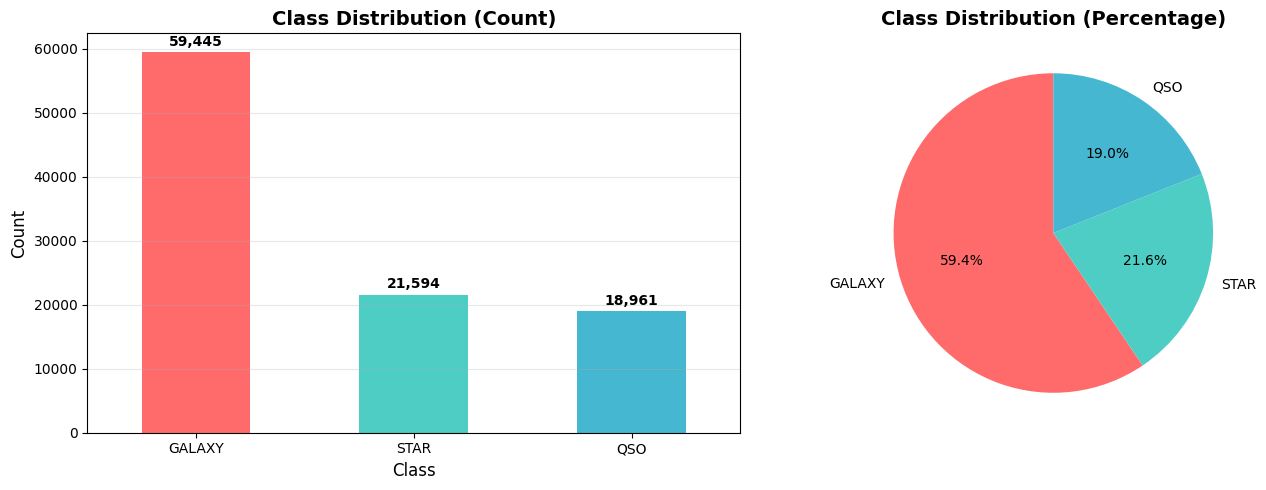

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_counts.plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(class_counts):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', va='bottom', fontweight='bold')

axes[1].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
            colors=['#FF6B6B', '#4ECDC4', '#45B7D1'], startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

**Feature Engineering**

In [12]:

def fe_pipeline(df_raw: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series, list[str], list[str]]:
    df2 = df_raw.copy()

    bands = ["u", "g", "r", "i", "z"]
    for c in bands:
        df2[c] = pd.to_numeric(df2[c], errors="coerce")
        df2.loc[df2[c] <= -1000, c] = np.nan

    df2["redshift"] = pd.to_numeric(df2["redshift"], errors="coerce")
    df2.loc[df2["redshift"] < -0.1, "redshift"] = np.nan

    # adjacent colors
    adj_pairs = [("u", "g"), ("g", "r"), ("r", "i"), ("i", "z")]
    for b1, b2 in adj_pairs:
        df2[f"{b1}_{b2}"] = df2[b1] - df2[b2]

    # all other pairwise colors
    adj_set = set(adj_pairs)
    pairwise = []
    for i in range(len(bands)):
        for j in range(i + 1, len(bands)):
            b1, b2 = bands[i], bands[j]
            if (b1, b2) in adj_set:
                continue
            name = f"{b1}_{b2}"
            df2[name] = df2[b1] - df2[b2]
            pairwise.append(name)

    color_feats = [f"{b1}_{b2}" for b1, b2 in adj_pairs] + pairwise

    # summary stats across mags
    df2["mean_mag"] = df2[bands].mean(axis=1)
    df2["mag_std"] = df2[bands].std(axis=1)
    df2["mag_span"] = df2[bands].max(axis=1) - df2[bands].min(axis=1)

    # curvature-like proxies
    df2["curv_ug_gr"] = df2["u_g"] - df2["g_r"]
    df2["curv_gr_ri"] = df2["g_r"] - df2["r_i"]

    eng_numeric = color_feats + ["mean_mag", "mag_std", "mag_span", "curv_ug_gr", "curv_gr_ri"]

    id_like_cols = [
        "obj_ID", "spec_obj_ID", "run_ID", "rerun_ID",
        "cam_col", "field_ID", "plate", "MJD", "fiber_ID",
    ]
    id_like_cols = [c for c in id_like_cols if c in df2.columns]
    for c in id_like_cols:
        df2[c] = df2[c].astype(str).astype("category")

    pos_cols = [c for c in ["alpha", "delta"] if c in df2.columns]

    core_numeric = pos_cols + bands + ["redshift"]
    feature_cols = core_numeric + eng_numeric + id_like_cols
    feature_cols = [c for c in feature_cols if c in df2.columns]

    if len(feature_cols) != len(set(feature_cols)):
        dupes = pd.Series(feature_cols).value_counts()
        raise ValueError(f"Duplicate feature names: {dupes[dupes > 1].to_dict()}")

    required_numeric = core_numeric + eng_numeric
    df2 = df2.dropna(subset=required_numeric + ["class"]).reset_index(drop=True)

    return df2, df2["class"], feature_cols, id_like_cols


In [13]:
#  Apply feature engineering to each split

df_train_fe, y_train_str, feature_cols, id_like_cols = fe_pipeline(df_train_full)
df_test_fe, y_test_str, _, _ = fe_pipeline(df_test_full)
df_prod_fe, y_prod_str, _, _ = fe_pipeline(df_prod_full)

# Align columns to training feature_cols
X_train = df_train_fe[feature_cols].copy()
X_test = df_test_fe[feature_cols].copy()
X_prod = df_prod_fe[feature_cols].copy()

print("Feature matrix shapes:")
print("  X_train:", X_train.shape)
print("  X_test: ", X_test.shape)
print("  X_prod: ", X_prod.shape)

Feature matrix shapes:
  X_train: (47999, 32)
  X_test:  (12000, 32)
  X_prod:  (40000, 32)


In [14]:
# Train/test + validation split

le = LabelEncoder()
y_all = le.fit_transform(y_train_str.astype(str))

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_all,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_all,
)

y_test = le.transform(y_test_str.astype(str))
y_prod = le.transform(y_prod_str.astype(str))

cat_features = [X_train.columns.get_loc(c) for c in id_like_cols]


## Models and Evaluation 

In [19]:
# models (CatBoost + LightGBM)

cat_model = CatBoostClassifier(
    loss_function="MultiClass",
    iterations=5000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=5.0,
    random_seed=RANDOM_STATE,
    auto_class_weights="Balanced",
    eval_metric="TotalF1",
    allow_writing_files=False,
    verbose=200,
)

cat_model.fit(
    X_tr,
    y_tr,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
    early_stopping_rounds=200,
)


lgbm_model = LGBMClassifier(
    objective="multiclass",
    n_estimators=8000,
    learning_rate=0.02,
    num_leaves=255,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    verbose=-1,
)

try:
    lgbm_model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
        categorical_feature=id_like_cols,
    )
except TypeError:
    lgbm_model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
    )

0:	learn: 0.9560252	test: 0.9546363	best: 0.9546363 (0)	total: 126ms	remaining: 10m 31s
200:	learn: 0.9713378	test: 0.9707454	best: 0.9712100 (196)	total: 27.3s	remaining: 10m 50s
400:	learn: 0.9745823	test: 0.9723034	best: 0.9723034 (396)	total: 56.7s	remaining: 10m 50s
600:	learn: 0.9772563	test: 0.9721208	best: 0.9725456 (504)	total: 1m 26s	remaining: 10m 31s
800:	learn: 0.9792570	test: 0.9725389	best: 0.9726710 (674)	total: 1m 55s	remaining: 10m 3s
1000:	learn: 0.9810756	test: 0.9730747	best: 0.9732509 (983)	total: 2m 24s	remaining: 9m 37s
1200:	learn: 0.9824759	test: 0.9733685	best: 0.9734857 (1190)	total: 2m 53s	remaining: 9m 9s
1400:	learn: 0.9840058	test: 0.9739116	best: 0.9739702 (1384)	total: 3m 23s	remaining: 8m 42s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9739701697
bestIteration = 1384

Shrink model to first 1385 iterations.


In [20]:
# evaluation

def eval_model(name, model, Xte, yte):
    pred = model.predict(Xte)
    macro = f1_score(yte, pred, average="macro")
    bal = balanced_accuracy_score(yte, pred)
    print(f"\n{name}")
    print("macro_f1:", round(macro, 6))
    print("balanced_acc:", round(bal, 6))
    print(classification_report(yte, pred, target_names=le.classes_, digits=4))
    cm = confusion_matrix(yte, pred)
    print(pd.DataFrame(
        cm,
        index=[f"true_{c}" for c in le.classes_],
        columns=[f"pred_{c}" for c in le.classes_],
    ))
    return macro, bal


In [21]:
cat_scores_test = eval_model(
    "CatBoost (IDs as categorical) – TEST",
    cat_model,
    X_test,
    y_test,
)

lgb_scores_test = eval_model(
    "LightGBM (with IDs) – TEST",
    lgbm_model,
    X_test,
    y_test,
)

print("\nTest scores:")
print("  CatBoost:", cat_scores_test)
print("  LightGBM:", lgb_scores_test)


CatBoost (IDs as categorical) – TEST
macro_f1: 0.972536
balanced_acc: 0.974781
              precision    recall  f1-score   support

      GALAXY     0.9833    0.9760    0.9797      7133
         QSO     0.9437    0.9495    0.9466      2276
        STAR     0.9840    0.9988    0.9914      2591

    accuracy                         0.9759     12000
   macro avg     0.9703    0.9748    0.9725     12000
weighted avg     0.9760    0.9759    0.9759     12000

             pred_GALAXY  pred_QSO  pred_STAR
true_GALAXY         6962       129         42
true_QSO             115      2161          0
true_STAR              3         0       2588

LightGBM (with IDs) – TEST
macro_f1: 0.972633
balanced_acc: 0.970228
              precision    recall  f1-score   support

      GALAXY     0.9768    0.9837    0.9802      7133
         QSO     0.9553    0.9293    0.9421      2276
        STAR     0.9935    0.9977    0.9956      2591

    accuracy                         0.9764     12000
   macro avg 

In [22]:
cat_scores_prod = eval_model(
    "CatBoost – PROD MONITOR",
    cat_model,
    X_prod,
    y_prod,
)

lgb_scores_prod = eval_model(
    "LightGBM – PROD MONITOR",
    lgbm_model,
    X_prod,
    y_prod,
)

print("\nProd-monitor scores:")
print("  CatBoost:", cat_scores_prod)
print("  LightGBM:", lgb_scores_prod)


CatBoost – PROD MONITOR
macro_f1: 0.974078
balanced_acc: 0.976524
              precision    recall  f1-score   support

      GALAXY     0.9849    0.9768    0.9808     23778
         QSO     0.9483    0.9533    0.9508      7584
        STAR     0.9819    0.9994    0.9906      8638

    accuracy                         0.9772     40000
   macro avg     0.9717    0.9765    0.9741     40000
weighted avg     0.9773    0.9772    0.9772     40000

             pred_GALAXY  pred_QSO  pred_STAR
true_GALAXY        23227       394        157
true_QSO             352      7230          2
true_STAR              5         0       8633

LightGBM – PROD MONITOR
macro_f1: 0.974829
balanced_acc: 0.972521
              precision    recall  f1-score   support

      GALAXY     0.9786    0.9852    0.9819     23778
         QSO     0.9599    0.9343    0.9469      7584
        STAR     0.9933    0.9980    0.9957      8638

    accuracy                         0.9783     40000
   macro avg     0.9773    0.